In [1]:
import pandas as pd
import torch
from transformers import AutoModelForMaskedLM
from src import perplexity, get_model, get_dataloaders
import matplotlib.pyplot
import seaborn as sns
sns.set_theme()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/home/agiottonini/miniconda3/envs/mes2therm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda', index=0)

# Statistics

Best model: `(('0.001', '256', '0.05'), tensor(1.7515))`

In [4]:
best_model_args = {
    "from_tokenizer": "Rostlab/prot_bert_bfd",
    "from_model": "Rostlab/prot_bert_bfd",
    "from_adapters": "./models/hps/LR0.001_BS256_P0.05/best/",
    "set": "./data/_test.csv",
    "min_length": None,
    "max_length": None,
    "local_batch_size": 8,
    "num_workers": 8,
    "mask": False,
    "p": 0
}

best_model, _, _ = get_model(best_model_args)
best_model.to(device)
best_model.to(torch.bfloat16)

base_model = AutoModelForMaskedLM.from_pretrained("Rostlab/prot_bert_bfd")
base_model.to(device)
base_model.to(torch.bfloat16)

dataloader, tokenizer, _ = get_dataloaders(best_model_args, get_training_and_validation=False)

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassificati

In [3]:
best_model_perplexity = torch.empty(0)
for batch in dataloader:
    input_ids = batch.input_ids
    attention_mask = batch.attention_mask
    perp = perplexity(model=best_model, input_ids=input_ids.to(device), attention_mask=attention_mask.to(device))
    best_model_perplexity = torch.concat([best_model_perplexity, perp.cpu().detach()])
best_model_perplexity = pd.Series(best_model_perplexity)

tensor([1.3047, 1.2031, 1.2812,  ..., 2.0000, 1.5781, 1.4766])

In [11]:
base_model_perplexity = torch.empty(0)
for batch in dataloader:
    input_ids = batch.input_ids
    attention_mask = batch.attention_mask
    perp = perplexity(model=base_model, input_ids=input_ids.to(device), attention_mask=attention_mask.to(device))
    base_model_perplexity = torch.concat([base_model_perplexity, perp.cpu()])
base_model_perplexity = pd.Series(base_model_perplexity)

<Axes: >

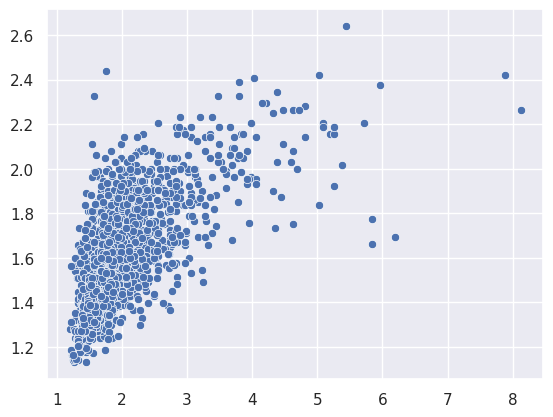

In [10]:
sns.scatterplot(x=base_model_perplexity, y=best_model_perplexity)